In [186]:
import numpy as np
import matplotlib.pyplot as plt
from ordpy import complexity_entropy
from ordpy import maximum_complexity_entropy, minimum_complexity_entropy

# Generate different time series
def generate_time_series(series_type, size=1000):
    if series_type == "lorenz":
        return generate_lorenz(size)
    elif series_type == "henon":
        return henon_map(size)
    elif series_type == "skewtent":
        return skew_tent_map(size)
    elif series_type == "logistic":
        return logistic_map(size)
    elif series_type == "schuster":
        return schuster_map(size)
    elif series_type == "whitenoise":
        return np.random.normal(0, 1, size)
    elif series_type == "regular":
        return np.sin(np.linspace(0, 20 * np.pi, size))
    else:
        raise ValueError("Unknown time series type")

def generate_lorenz(size):
    from scipy.integrate import solve_ivp

    def lorenz_system(t, state):
        sigma, rho, beta, d0 = 10.0, 28.0, 8.0 / 3.0, 19.0 / 3.0
        x, y, z, y1, z1 = state
        return [
            sigma * (y - x),
            x * (rho - z) - y,
            x * y - x * y1 - beta * z,
            x * z - 2 * x * z1 - d0 * y1,
            2 * x * y1 - 4 * beta * z1,
        ]

    initial_state = [1.0, 1.0, 1.0, 1.0, 1.0]
    t_span = [0, 40]
    t_eval = np.linspace(t_span[0], t_span[1], size)
    solution = solve_ivp(lorenz_system, t_span, initial_state, t_eval=t_eval, method='RK45')
    return solution.y[0]

def henon_map(size, a=1.4, b=0.3, x0=.4):
    x = np.zeros(size)
    y = np.zeros(size)
    x[0] = x0
    for i in range(1, len(x)):
        x[i] = 1 - a * x[i-1] ** 2 + y[i-1]
        y[i] = b * x[i-1]
    return x

def skew_tent_map(size):
    x = np.zeros(size)
    x[0] = 0.1
    mu = 2
    for i in range(1, size):
        if x[i - 1] < 1 / 2:
            x[i] = x[i - 1] * mu
        else:
            x[i] = (1 - x[i - 1]) * mu
    return x

def logistic_map(size):
    x = np.zeros(size)
    r = 4.0
    x[0] = 0.7
    for i in range(1, size):
        x[i] = r * x[i - 1] * (1 - x[i - 1])
    return x

def schuster_map(size, q=0.5):
    x = np.zeros(size)
    x[0] = 0.1
    for i in range(1, size):
        x[i] = np.mod(x[i - 1] + q / (2 * np.pi), 1)
    return x

# Calculate entropy and complexity for each time series
series_types = ["lorenz", "henon", "skewtent", "logistic", "schuster", "whitenoise", "regular"]
results = {}

for series_type in series_types:
    data = generate_time_series(series_type)
    entropy, complexity = complexity_entropy(data, dx=3)
    results[series_type] = (entropy, complexity)

In [187]:
from collections import Counter


def get_uniform_dist(size: int) -> np.ndarray:
    return np.array([1 / size] * size)

def get_series_proba(series: np.ndarray, s: int = 5) -> np.ndarray:
    permutations = []
    for idx in range(0, len(series) - s):
        z = series[idx:idx + s]
        permutations.append(tuple(np.argsort(z)))
    counter = Counter(permutations)

    probas = [c / sum(counter.values()) for c in counter.values()]
    return np.array(probas + [0.0] * (len(probas) - np.prod(range(1, s + 1))))

def get_shannon_entropy(probas: np.ndarray) -> float:
    return -np.sum([p * np.log(p) if p > 0 else 0.0 for p in probas])

def get_normalized_shannon_entropy(probas: np.ndarray) -> float:
    uniform_probas = get_uniform_dist(len(probas))

    return get_shannon_entropy(probas) / get_shannon_entropy(uniform_probas)

def get_jensen_shannon_divergence(probas: np.ndarray) -> float:
    s = len(probas)
    uniform_probas = get_uniform_dist(s)

    return get_shannon_entropy((probas + uniform_probas) / 2) - get_shannon_entropy(probas) / 2 - get_shannon_entropy(uniform_probas) / 2

def get_complexity(probas: np.ndarray) -> float:
    normalize_const = get_jensen_shannon_divergence(np.array([1.0] + [0.0] * (len(probas) - 1)))

    return get_jensen_shannon_divergence(probas) / normalize_const * get_normalized_shannon_entropy(probas)

In [188]:
results = {}
for series_type in series_types:
    data = generate_time_series(series_type)
    probas = get_series_proba(data)
    entropy = get_normalized_shannon_entropy(probas)
    complexity = get_complexity(probas)
    results[series_type] = (entropy, complexity)

In [189]:
results

{'lorenz': (0.8307085466205624, 0.20263760045985205),
 'henon': (0.8996334619781693, 0.12751513407550336),
 'skewtent': (0.13578593820259355, 0.11223158313730332),
 'logistic': (0.9368815328910839, 0.0808301803496006),
 'schuster': (0.6619132616054486, 0.19333639160898292),
 'whitenoise': (0.9892339377836828, 0.018972963114006206),
 'regular': (0.38990280976863184, 0.257268735579721)}

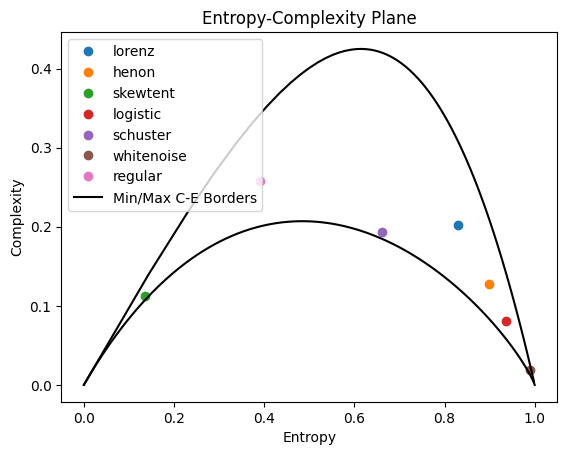

In [190]:
# Plot results
fig, ax = plt.subplots()
for series_type, (entropy, complexity) in results.items():
    ax.plot(entropy, complexity, 'o', label=series_type)

# Draw boundary with ordpy
min_complexity_entropy = minimum_complexity_entropy(dx=5)
max_complexity_entropy = maximum_complexity_entropy(dx=5)

ax.plot(min_complexity_entropy[:, 0], min_complexity_entropy[:, 1], 'k-', label='Min/Max C-E Borders')
ax.plot(max_complexity_entropy[:, 0], max_complexity_entropy[:, 1], 'k-')

ax.set_xlabel('Entropy')
ax.set_ylabel('Complexity')
ax.set_title('Entropy-Complexity Plane')
ax.legend()
plt.show()